# Improved PPO Training for Maglev Pod

## Major Changes to Enable Learning:

### 1. **Reward Function (lev_pod_env.py)**
**Problem**: Squared penalties created rewards of -7000 to -8200, making learning impossible
- `(gap_error * 100)²` could reach 10,000+ for small errors
- +1.0 survival bonus was meaningless compared to penalties

**Solution**: Exponential reward shaping with reasonable scales
- Gap reward: `exp(-0.5 * (error/3mm)²)` → smooth 0 to 1.0 range
- Small linear penalties for orientation (~0.02/degree)
- Success bonus: +2.0 for excellent hovering (gap < 1mm, angles < 2°)
- **New reward range: -10 to +3 per step** (was -8200 to +1 total)

### 2. **Network Architecture**
**Changes**:
- Increased hidden units: 128 → 256
- Added LayerNorm for training stability
- Deeper shared layers (3 layers instead of 2)
- Better initialization for exploration

### 3. **Training Hyperparameters**
**Changes**:
- Policy LR: 3e-4 → 5e-4 (faster learning)
- Value LR: 3e-4 → 1e-3 (even faster value updates)
- Entropy coefficient: 0.01 → 0.02 (more exploration)
- Added gradient clipping (max norm 0.5)
- GAE lambda: 0.97 → 0.95 (less biased advantage estimates)
- Episodes: 1000 → 2000

### 4. **Termination Conditions**
**Tightened for safety**:
- Gap bounds: 2-40mm → 3-35mm
- Angle tolerance: 20° → 15°
- Failure penalty: -50 → -10 (scaled with new rewards)

## Expected Behavior:
- **Rewards should be positive or mildly negative** during good episodes
- **Gap error should steadily decrease** from initial ~15mm toward target 16.49mm
- **Episodes that reach 500 steps** indicate successful hovering
- **Look for improvement over first 500 episodes**, then fine-tuning after

In [1]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from torch import nn
from torch import optim
from torch.distributions import Normal
from lev_pod_env import LevPodEnv

In [2]:
print("Torch Version:", torch.__version__)
print("CUDA Available:", torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Torch Version: 2.8.0
CUDA Available: True
Using device: cuda


In [3]:
class ActorCriticNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super().__init__()
        # Larger network with layer normalization for better learning
        self.shared_layers = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU()
        )
        # Policy outputs mean and log_std for continuous actions
        self.policy_mean = nn.Sequential(
            nn.Linear(hidden_dim // 2, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, action_dim),
            nn.Tanh()  # Constrain to [-1, 1] range
        )
        # Initialize log_std to encourage exploration initially
        self.policy_log_std = nn.Parameter(torch.ones(action_dim) * -0.5)
        
        self.value_layers = nn.Sequential(
            nn.Linear(hidden_dim // 2, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 1),
        )

    def value(self, observation):
        shared_output = self.shared_layers(observation)
        state_value = self.value_layers(shared_output)
        return state_value
    
    def policy(self, observation):
        shared_output = self.shared_layers(observation)
        mean = self.policy_mean(shared_output)
        std = torch.exp(self.policy_log_std)
        return mean, std
    
    def forward(self, state):
        shared_output = self.shared_layers(state)
        mean = self.policy_mean(shared_output)
        std = torch.exp(self.policy_log_std)
        state_value = self.value_layers(shared_output)
        return mean, std, state_value

In [4]:
class PPOTrainer():
    def __init__(self, actor_critic, ppo_clip_val=0.2, target_kl_div=0.02,
                  max_policy_train_iters=40, value_train_iters=40, policy_lr=5e-4, value_lr=1e-3, 
                  entropy_coef=0.02):
        self.ac = actor_critic
        self.ppo_clip_val = ppo_clip_val
        self.target_kl_div = target_kl_div
        self.max_policy_train_iters = max_policy_train_iters
        self.value_train_iters = value_train_iters
        self.entropy_coef = entropy_coef

        policy_params = list(self.ac.shared_layers.parameters()) + \
                       list(self.ac.policy_mean.parameters()) + \
                       [self.ac.policy_log_std]
        self.policy_optimizer = optim.Adam(policy_params, lr=policy_lr)

        value_params = list(self.ac.shared_layers.parameters()) + \
                      list(self.ac.value_layers.parameters())
        self.value_optimizer = optim.Adam(value_params, lr=value_lr)

    def train_policy(self, obs, acts, old_log_probs, gaes):
        for _ in range(self.max_policy_train_iters):
            self.policy_optimizer.zero_grad()

            new_mean, new_std = self.ac.policy(obs)
            new_dist = Normal(new_mean, new_std)
            new_log_probs = new_dist.log_prob(acts).sum(dim=-1)

            policy_ratio = torch.exp(new_log_probs - old_log_probs)
            clipped_ratio = policy_ratio.clamp(1 - self.ppo_clip_val, 1 + self.ppo_clip_val)

            clipped_loss = clipped_ratio * gaes
            unclipped_loss = policy_ratio * gaes

            policy_loss = -torch.min(clipped_loss, unclipped_loss).mean()
            
            # Increased entropy bonus to encourage more exploration
            entropy = new_dist.entropy().mean()
            policy_loss = policy_loss - self.entropy_coef * entropy

            policy_loss.backward()
            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(self.policy_optimizer.param_groups[0]['params'], 0.5)
            self.policy_optimizer.step()

            kl_div = (old_log_probs - new_log_probs).mean()
            if kl_div > self.target_kl_div:
                break
          
    def train_value(self, obs, returns):
        for _ in range(self.value_train_iters):
            self.value_optimizer.zero_grad()

            values = self.ac.value(obs)
            value_loss = (returns - values).pow(2).mean()
            
            value_loss.backward()
            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(self.value_optimizer.param_groups[0]['params'], 0.5)
            self.value_optimizer.step()

In [5]:
def discount_rewards(rewards, gamma=0.99):
    discounted = np.zeros_like(rewards, dtype=np.float32)
    running_add = 0
    for t in reversed(range(len(rewards))):
        running_add = running_add * gamma + rewards[t]
        discounted[t] = running_add
    return discounted

def calculate_gaes(rewards, values, gamma=0.99, lam=0.95):
    # Add 0 for terminal state bootstrap value
    next_values = np.concatenate([values[1:], [0]])
    deltas = rewards + gamma * next_values - values
    gaes = discount_rewards(deltas, gamma * lam)
    return gaes

In [6]:
def rollout(model, env, max_steps=500):  
    train_data = [[],[],[],[],[]]  # obs, actions, rewards, values, log_probs
    gap_heights = []  # Track gap heights during episode
    obs, _ = env.reset()  # Gymnasium returns (obs, info)
    
    ep_reward = 0
    for _ in range(max_steps):
        with torch.no_grad():  # No gradients needed during rollout
            mean, std, val = model(torch.tensor([obs], dtype=torch.float32, device=device))

        # Sample continuous action from Normal distribution
        act_distribution = Normal(mean, std)
        act = act_distribution.sample()
        act_log_prob = act_distribution.log_prob(act).sum(dim=-1)
        
        # Convert to numpy array for environment
        act_np = act.squeeze(0).cpu().numpy()
        next_obs, reward, terminated, truncated, _ = env.step(act_np)
        
        # Extract gap heights from observation (first 4 values are normalized gaps)
        # Denormalize gaps: multiply by gap_scale (0.015m = 15mm)
        gap_heights.append(obs[:4] * env.gap_scale * 1000)  # Convert to mm

        # Store as Python scalars (moving to CPU only when necessary)
        for i, item in enumerate([obs, act_np, reward, val.item(), act_log_prob.item()]):
            train_data[i].append(item)
        
        obs = next_obs
        ep_reward += reward
        done = terminated or truncated

        if done:
            break
        
    train_data = [np.array(x, dtype=np.float32) for x in train_data]
    train_data[3] = calculate_gaes(rewards=train_data[2], values=train_data[3])
    
    # Calculate average gap height error
    gap_heights = np.array(gap_heights)  # Shape: (steps, 4 sensors)
    avg_gap_per_step = gap_heights.mean(axis=1)  # Average across 4 sensors
    target_gap_mm = 16.491741
    avg_gap_error = np.abs(avg_gap_per_step - target_gap_mm).mean()

    return train_data, ep_reward, avg_gap_error

In [ ]:
# The following was generated by AI - see [19]
environ = LevPodEnv(use_gui=False, initial_gap_mm=14, max_steps=500)  # Start below target
model = ActorCriticNetwork(environ.observation_space.shape[0], environ.action_space.shape[0]).to(device)
train_data, reward, gap_error = rollout(model, environ)
print("Reward:", reward)
print("Episode length:", len(train_data[0]))
print("Reward per step:", reward / len(train_data[0]))
print(f"Average gap error: {gap_error:.3f} mm")

# Calculate theoretical maximum reward for reference (NEW REWARD STRUCTURE)
max_steps = 500
# Best case: gap_reward=1.0, no penalties, success_bonus=2.0
theoretical_max_per_step = 3.0  # 1.0 (gap) + 2.0 (success bonus) + 0 (no penalties)
# Realistic good case: gap_reward~0.9, small penalties
realistic_good_per_step = 0.8
theoretical_max_total = theoretical_max_per_step * max_steps
realistic_good_total = realistic_good_per_step * max_steps

print(f"\nTheoretical Maximum:")
print(f"  Best per step: {theoretical_max_per_step:.2f}")
print(f"  Realistic good per step: {realistic_good_per_step:.2f}")
print(f"  Best total (500 steps): {theoretical_max_total:.0f}")
print(f"  Current % of realistic: {(reward/realistic_good_total)*100:.1f}%")

Loading maglev model from maglev_model.pkl...
Model loaded. Degree: 6
Force R2: 1.0000
Torque R2: 0.9999


C:\Users\pulip\AppData\Local\Temp\ipykernel_32220\3744901434.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\bld\libtorch_1762089177580\work\torch\csrc\utils\tensor_new.cpp:256.)
  mean, std, val = model(torch.tensor([obs], dtype=torch.float32, device=device))


Reward: 1990.308654679309
Episode length: 500
Reward per step: 3.980617309358618
Average gap error: 19.005 mm

Theoretical Maximum:
  Best per step: 3.00
  Realistic good per step: 0.80
  Best total (500 steps): 1500
  Current % of realistic: 497.6%


## Key Improvements Made:

1. **Better Reward Scaling**: Changed from squared penalties (up to 10,000+) to exponential rewards (~0 to 1) with smaller linear penalties
2. **Larger Network**: Increased from 128 to 256 hidden units with LayerNorm for better learning capacity
3. **More Exploration**: Increased entropy coefficient from 0.01 to 0.02, initialized log_std higher
4. **Gradient Clipping**: Added to prevent exploding gradients
5. **Higher Learning Rates**: Increased policy LR to 5e-4 and value LR to 1e-3
6. **Tighter Termination**: Reduced angle tolerance to 15° and gap bounds to 3-35mm
7. **Success Bonus**: Added +2.0 reward for excellent hovering (gap < 1mm, angles < 2°)

Expected improvements:
- Rewards should now be in range [-10, +3] instead of [-8000, +1]
- Model should learn meaningful distinctions between good and bad states
- Training should show steady improvement in gap error over episodes

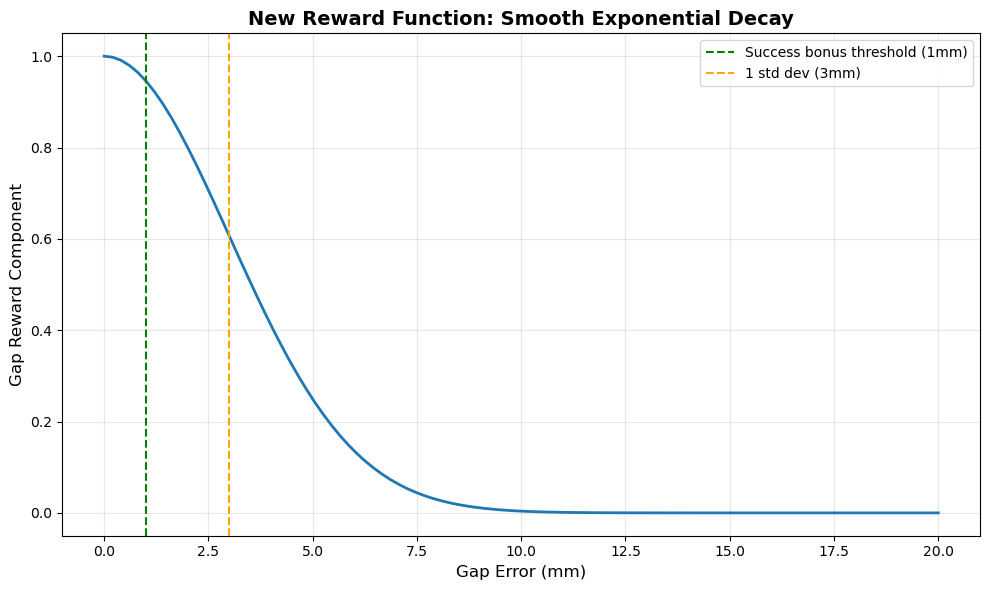

Reward examples at different gap errors:
   0mm error → 1.0000 reward
   1mm error → 0.9460 reward
   3mm error → 0.6065 reward
   5mm error → 0.2494 reward
  10mm error → 0.0039 reward
  15mm error → 0.0000 reward

Compare to old reward: (error*100)² would be:
   1mm error → -10,000 penalty
   3mm error → -90,000 penalty
   5mm error → -250,000 penalty
  10mm error → -1,000,000 penalty


In [ ]:
# The following was generated by AI - see [20]
# Visualize the new reward function
gap_errors_mm = np.linspace(0, 20, 100)
gap_rewards = np.exp(-0.5 * (gap_errors_mm / 3.0)**2)

plt.figure(figsize=(10, 6))
plt.plot(gap_errors_mm, gap_rewards, linewidth=2)
plt.axvline(x=1.0, color='g', linestyle='--', label='Success bonus threshold (1mm)')
plt.axvline(x=3.0, color='orange', linestyle='--', label='1 std dev (3mm)')
plt.xlabel('Gap Error (mm)', fontsize=12)
plt.ylabel('Gap Reward Component', fontsize=12)
plt.title('New Reward Function: Smooth Exponential Decay', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

print("Reward examples at different gap errors:")
for err in [0, 1, 3, 5, 10, 15]:
    reward = np.exp(-0.5 * (err / 3.0)**2)
    print(f"  {err:2d}mm error → {reward:.4f} reward")
print("\nCompare to old reward: (error*100)² would be:")
for err in [1, 3, 5, 10]:
    old_penalty = (err * 100)**2
    print(f"  {err:2d}mm error → -{old_penalty:,} penalty")

In [ ]:
# The following was generated by AI - see [21]
import os
from datetime import datetime

# Create RL_Trials folder if it doesn't exist
os.makedirs('RL_Trials', exist_ok=True)

# Create timestamped log file
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
log_file_path = f'RL_Trials/training_log_{timestamp}.txt'
plot_file_path = f'RL_Trials/gap_error_plot_{timestamp}.png'

# Define training params
num_episodes = 2000  # Increased for more learning time
print_freq = 20  # Print less frequently
gui_freq = 100  # Show GUI every 100 episodes

# Create PPO trainer with improved hyperparameters
ppo = PPOTrainer(
    model, 
    policy_lr=5e-4,          # Higher learning rate
    value_lr=1e-3,           # Even higher for value function
    target_kl_div=0.02,      # Allow more policy updates
    max_policy_train_iters=40,
    value_train_iters=40,
    entropy_coef=0.02        # More exploration
)

# Open log file
log_file = open(log_file_path, 'w')
log_file.write(f"Training Started: {timestamp}\n")
log_file.write(f"Number of Episodes: {num_episodes}\n")
log_file.write(f"Print Frequency: {print_freq}\n")
log_file.write(f"Target Gap Height: {16.491741} mm\n")
log_file.write(f"Network: 256 hidden units with LayerNorm\n")
log_file.write(f"Policy LR: 5e-4, Value LR: 1e-3, Entropy: 0.02\n")
log_file.write("="*70 + "\n\n")
log_file.flush()

print(f"Logging to: {log_file_path}")
print(f"Plot will be saved to: {plot_file_path}")

Logging to: RL_Trials/training_log_20251211_191801.txt
Plot will be saved to: RL_Trials/gap_error_plot_20251211_191801.png


In [10]:
environ = LevPodEnv(use_gui=True, initial_gap_mm=14, max_steps=500)  # Start below target

Loading maglev model from maglev_model.pkl...
Model loaded. Degree: 6
Force R2: 1.0000
Torque R2: 0.9999


In [11]:
# Training Loop with Better Monitoring
ep_rewards = []
ep_lengths = []
ep_gap_errors = []
best_gap_error = float('inf')
gui_env = None

for episode_idx in range(num_episodes):
  train_data, ep_reward, gap_error = rollout(model, environ)
  
  ep_length = len(train_data[0])
  ep_rewards.append(ep_reward)
  ep_lengths.append(ep_length)
  ep_gap_errors.append(gap_error)
  
  # Track best performance
  if gap_error < best_gap_error:
    best_gap_error = gap_error

  # Data Formatting
  permute_idxs = np.random.permutation(len(train_data[0]))
  obs = torch.tensor(train_data[0][permute_idxs], dtype=torch.float32, device=device)
  acts = torch.tensor(train_data[1][permute_idxs], dtype=torch.float32, device=device)
  gaes = torch.tensor(train_data[3][permute_idxs], dtype=torch.float32, device=device)
  act_log_probs = torch.tensor(train_data[4][permute_idxs], dtype=torch.float32, device=device)

  returns = discount_rewards(train_data[2])[permute_idxs]
  returns = torch.tensor(returns, dtype=torch.float32, device=device)

  # Normalize GAEs for stable training
  gaes = (gaes - gaes.mean()) / (gaes.std() + 1e-8)

  ppo.train_policy(obs, acts, act_log_probs, gaes)
  ppo.train_value(obs, returns)

  if (episode_idx + 1) % print_freq == 0:
    avg_reward = np.mean(ep_rewards[-print_freq:])
    avg_length = np.mean(ep_lengths[-print_freq:])
    avg_gap_error = np.mean(ep_gap_errors[-print_freq:])
    min_gap_error = np.min(ep_gap_errors[-print_freq:])
    avg_reward_per_step = avg_reward / avg_length if avg_length > 0 else 0
    
    # Updated for new reward scale (realistic good is ~0.8/step)
    realistic_good_per_step = 0.8
    percent_of_realistic = (avg_reward_per_step / realistic_good_per_step) * 100
    
    output_line = (f"Ep {episode_idx + 1:4d} | R: {avg_reward:6.1f} | Len: {avg_length:3.0f} | "
                   f"R/s: {avg_reward_per_step:5.2f} ({percent_of_realistic:5.1f}%) | "
                   f"Gap: {avg_gap_error:5.2f}mm (min:{min_gap_error:5.2f}) | Best: {best_gap_error:5.2f}mm")
    
    print(output_line)
    log_file.write(output_line + "\n")
    log_file.flush()

# Close GUI environment if created
if gui_env is not None:
  gui_env.close()

# Close log file
log_file.write("\n" + "="*70 + "\n")
log_file.write(f"Training Completed: {datetime.now().strftime('%Y%m%d_%H%M%S')}\n")
log_file.write(f"Best Gap Error Achieved: {best_gap_error:.3f} mm\n")
log_file.close()

Ep   20 | R:  755.5 | Len: 204 | R/s:  3.70 (462.3%) | Gap: 16.74mm (min:14.73) | Best: 14.73mm
Ep   40 | R:  407.2 | Len: 116 | R/s:  3.52 (439.9%) | Gap: 15.56mm (min:13.80) | Best: 13.80mm
Ep   60 | R:  157.4 | Len:  57 | R/s:  2.78 (347.5%) | Gap: 14.87mm (min:13.91) | Best: 13.80mm
Ep   80 | R:  182.7 | Len:  61 | R/s:  2.98 (372.0%) | Gap: 15.06mm (min:14.21) | Best: 13.80mm
Ep  100 | R:  487.2 | Len: 134 | R/s:  3.65 (455.9%) | Gap: 16.10mm (min:14.31) | Best: 13.80mm
Ep  120 | R: 1113.1 | Len: 297 | R/s:  3.75 (468.3%) | Gap: 17.64mm (min:15.95) | Best: 13.80mm
Ep  140 | R: 1434.7 | Len: 385 | R/s:  3.72 (465.6%) | Gap: 18.21mm (min:16.13) | Best: 13.80mm
Ep  160 | R:  641.4 | Len: 172 | R/s:  3.72 (464.8%) | Gap: 16.69mm (min:15.38) | Best: 13.80mm
Ep  180 | R: 1029.0 | Len: 274 | R/s:  3.76 (469.7%) | Gap: 17.43mm (min:14.60) | Best: 13.80mm
Ep  200 | R:  287.0 | Len:  85 | R/s:  3.39 (424.0%) | Gap: 15.61mm (min:14.18) | Best: 13.80mm
Ep  220 | R:  330.9 | Len:  94 | R/s:  3

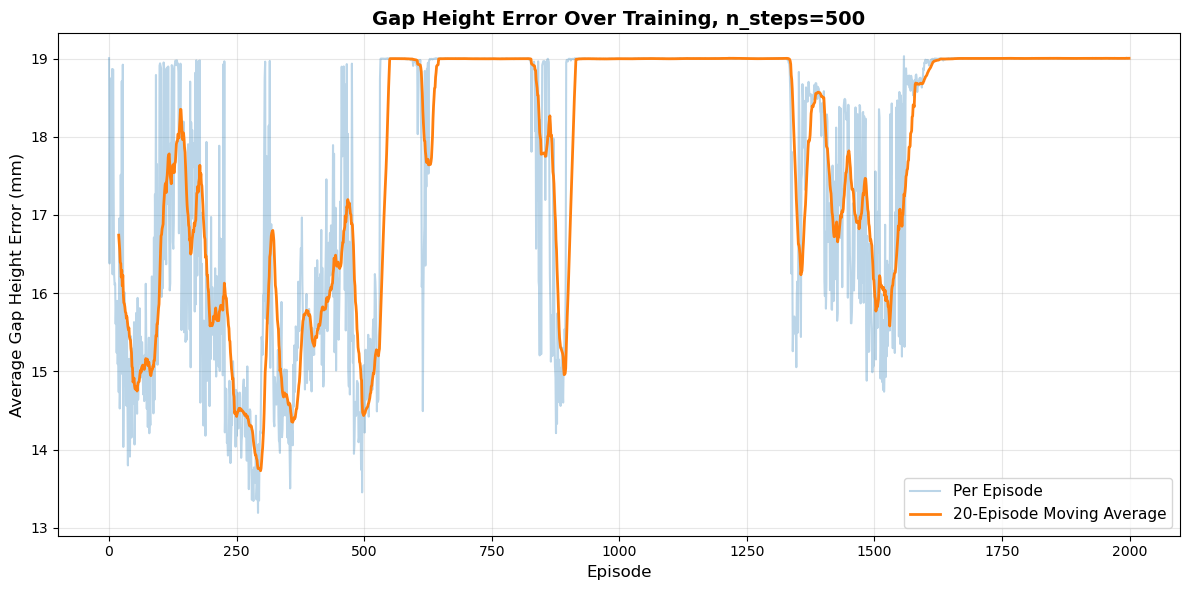


✓ Training log saved to: RL_Trials/training_log_20251211_191801.txt
✓ Gap error plot saved to: RL_Trials/gap_error_plot_20251211_191801.png


In [ ]:
# Create and save gap error plot
plt.figure(figsize=(12, 6))
plt.plot(ep_gap_errors, alpha=0.3, label='Per Episode')

# Calculate moving average (window size = print_freq)
window_size = print_freq
if len(ep_gap_errors) >= window_size:
    moving_avg = np.convolve(ep_gap_errors, np.ones(window_size)/window_size, mode='valid')
    plt.plot(range(window_size-1, len(ep_gap_errors)), moving_avg, linewidth=2, label=f'{window_size}-Episode Moving Average')

plt.xlabel('Episode', fontsize=12)
plt.ylabel('Average Gap Height Error (mm)', fontsize=12)
plt.title('Gap Height Error Over Training, n_steps=500', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(plot_file_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Training log saved to: {log_file_path}")
print(f"✓ Gap error plot saved to: {plot_file_path}")

In [13]:
environ.close()